# Hodgkin-Huxley Neuron Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Define the `HH` class

In [2]:
class HH():
    def __init__(self):
        self.t = 0.
        self.v = 0.
        self.m = 0.
        self.h = 0.
        self.n = 0.
        
        # Derivatives
        self.dV = 0.
        self.dm = 0.
        self.dh = 0.
        self.dn = 0.
        
        self.cm = 0.02  # membrane capacitance (mS/mm^2)
        
        # Set all the maximal channel conductances
        self.gL = 0.003
        self.gK = 0.36
        self.gNa = 1.2

        # Set the reverse potentials
        self.EL = -54.387
        self.EK = -77
        self.ENa = 50

        self.input_current = (lambda t: 0.)
        
    @classmethod
    def nGate(cls, V):
        '''
            Evaluates the steady-state value and time constant for subgate n.
≠
            n_inf, tau_n = HH.nGate(V)

            Input:
              V is the voltage (scalar) in mV

            Output:
              n_inf is the steady-state value of n
              tau_n is the time constant for n, measured in ms
        '''
        # Find the values that are NOT divide-by-zero
        if (abs(V+55)>1e-5):
            #alpha = (0.01*(V+55)) / (1-exp(-0.1*(V+55)))
            alpha = (0.01*(V+55)) / (1-np.exp(-0.1*(V+55)))
        else:
            # In the case of a divide-by-zero, the value should be 0.1.
            alpha = 0.1

        beta = 0.125*np.exp(-0.0125*(V+65))

        tau_n = 1 / (alpha + beta)
        n_inf = alpha *tau_n

        return [n_inf, tau_n]

    @classmethod
    def mGate(cls, V):

        # Find the values that are NOT divide-by-zero
        if (abs(V+40)>1e-5):
            alpha = (0.1*(V+40)) / (1 - np.exp(-0.1*(V+40)) )
        else:
            # In the case of a divide-by-zero, the value should be 1.
            alpha = 1.0

        beta = 4*np.exp(-0.0556*(V+65))

        tau_m = 1.0 / (alpha + beta)
        m_inf = alpha * tau_m

        return [m_inf, tau_m]

    @classmethod
    def hGate(cls, V):

        # No divide-by-zero to worry about here.
        alpha = 0.07*np.exp(-0.05*(V+65))
        beta = 1. / ( 1 + np.exp(-0.1*(V+35)) )

        tau_h = 1. / (alpha + beta)
        h_inf = alpha * tau_h

        return [h_inf, tau_h]


    def axon(self):
        output = max(0, self.v-self.EL)
        return output
        
    def simulate(self, tspan, dt):
        s = 1000.
        start_ms = tspan[0]*s   # convert to ms
        end_ms = tspan[1]*s
        dt_ms = dt * s
        
        t_ms = start_ms
        y = np.array([self.v, self.m, self.h, self.n])
        
        sol = dict(t=[], y=[])
        sol['y'].append(y)
        sol['t'].append(t_ms/s)
        
        while t_ms<end_ms:
            self.slope(t_ms)  # evaluate RHS of differential equations
            self.step(dt_ms)  # use Euler's method to take a step
            
            t_ms += dt_ms
            sol['t'].append(t_ms/s)  # record in seconds
            sol['y'].append(np.array([self.v, self.m, self.h, self.n]))
            
        sol['t'] = np.array(sol['t'])
        sol['y'] = np.array(sol['y'])
        return sol
        
        
    def slope(self, t):
        # Find out what the channels are up to at this voltage.
        
        s = 1000.
        V = self.v
        ninf, taun = HH.nGate(V)
        minf, taum = HH.mGate(V)
        hinf, tauh = HH.hGate(V)

        Ie = self.input_current(t/s)  # time is in seconds
        
        # Compute the overall membrane potential
        I = (self.gL*(V-self.EL) +
                    self.gK*self.n**4*(V-self.EK) +
                    self.gNa*self.m**3*self.h*(V-self.ENa))

        # Here is the system of differential equations.
        # This is the right-hand-side of the system of 4 equations.
        self.dV = (-I+Ie)/self.cm
        self.dn = (ninf-self.n)/taun
        self.dm = (minf-self.m)/taum
        self.dh = (hinf-self.h)/tauh


    def step(self, dt):
        # Take an Euler step forward in time
        self.v += dt*self.dV
        self.m += dt*self.dm
        self.h += dt*self.dh
        self.n += dt*self.dn
        return [self.v, self.m, self.h, self.n]

## Plot $n_\infty$, $m_\infty$, and $h_\infty$

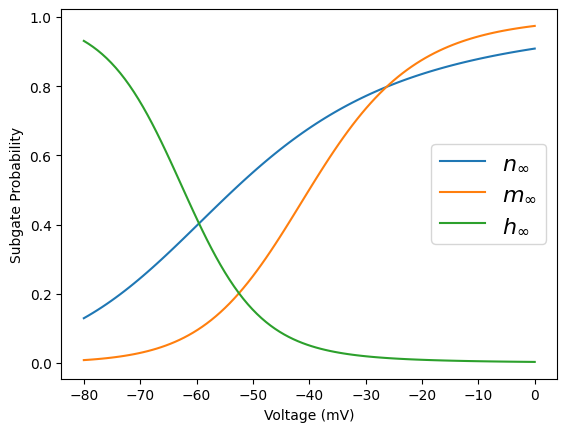

In [3]:
# Plot n, m and h curves as a function of voltage
Vs = np.linspace(-80, 0, 100)
ns = np.array([HH.nGate(v)[0] for v in Vs])
ms = np.array([HH.mGate(v)[0] for v in Vs])
hs = np.array([HH.hGate(v)[0] for v in Vs])
plt.plot(Vs, ns); plt.plot(Vs, ms); plt.plot(Vs, hs);
plt.legend([r'$n_\infty$', r'$m_\infty$', r'$h_\infty$'], fontsize=16);
plt.xlabel('Voltage (mV)'); plt.ylabel('Subgate Probability');

# Simulate

## Set up the model

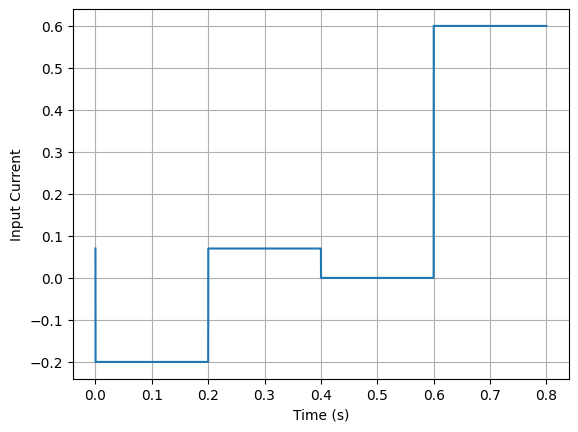

In [4]:
# Set the time span for the simulation (in ms)
dt = 0.00001 # length of time step, in units of s
t = np.arange(0.0, 0.8, dt)  # Again, in units of s

# Set the initial state vector
#            V              m           h            n
z0 = [-53.14669365,   0.18920957,   0.21004222,   0.50796341]

# Define a function that evaluates the injected current at any time t.
def InjectedCurrent(t):
    '''
    I = InjectedCurrent(t)
    where t is time (measured in ms)
    and I is the current (measured in mA)
    '''
    if t>0.0 and t<0.2:
        return -0.2
    elif t<0.4:
        return 0.07
    elif t<0.6:
        return 0.
    else:
        return 0.6

J = [InjectedCurrent(tt) for tt in t]
plt.figure()
plt.plot(t, J);
plt.grid(True); plt.xlabel('Time (s)'); plt.ylabel('Input Current');

## Run the model

In [5]:
hh = HH()
tspan = [0, 0.8]
dt = 0.00001
hh.input_current = InjectedCurrent
sol = hh.simulate(tspan, dt)

## Plot Membrane Potential

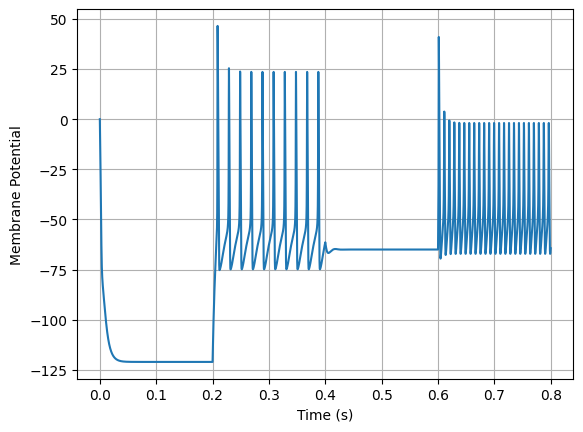

In [6]:
plt.plot(sol['t'], sol['y'][:,0])
plt.grid('on'); plt.xlabel('Time (s)'); plt.ylabel('Membrane Potential');

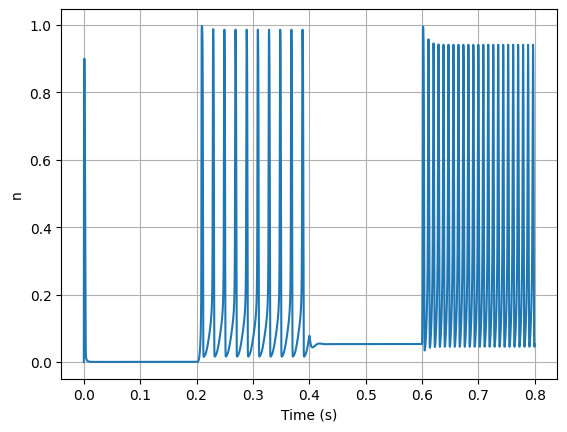

In [7]:
plt.plot(sol['t'], sol['y'][:,1])
plt.grid('on'); plt.xlabel('Time (s)'); plt.ylabel('n');

## Close-up of an action potential

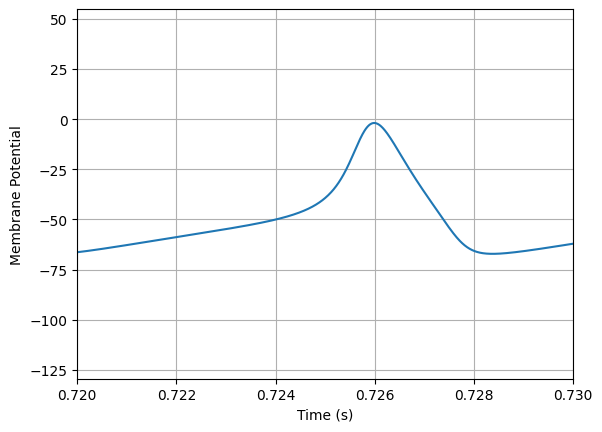

In [8]:
plt.plot(sol['t'], sol['y'][:,0])
plt.grid('on');
ax = plt.gca()
ax.set_xlim(0.72, 0.73); plt.xlabel('Time (s)'); plt.ylabel('Membrane Potential');